In [11]:
# Boilerplate from Randy cheatsheet at https://docs.google.com/document/d/1utZuLHcKQEZNXTQLOysTNCxTHrqxczAUymmtplpn27Q/edit#
import pandas as pd
import geopandas as gpd
import numpy as np
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline
pd.set_option('display.max_columns', 500)

# Wide display
from IPython.core.display import display, HTML
display(HTML("<style>#notebook-container { margin-left:-14px; width:calc(100% + 27px) !important; }</style>"))

In [142]:
import pandas as pd
import csv, json, os, math, numbers, pandas, re, scipy, scipy.sparse, shutil
import struct, subprocess, sys, threading, time, urllib2

def exec_ipynb(filename_or_url):
    nb = (urllib2.urlopen(filename_or_url) if re.match(r'https?:', filename_or_url) else open(filename_or_url)).read()
    jsonNb = json.loads(nb)
    #check for the modified formatting of Jupyter Notebook v4
    if(jsonNb['nbformat'] == 4):
        exec '\n'.join([''.join(cell['source']) for cell in jsonNb['cells'] if cell['cell_type'] == 'code']) in globals()
    else:
        exec '\n'.join([''.join(cell['input']) for cell in jsonNb['worksheets'][0]['cells'] if cell['cell_type'] == 'code']) in globals()

exec_ipynb('timelapse-utilities.ipynb')

In [143]:
def get_segments_from_ring(r):
    ret = set()
    for i in range(0, len(r)):
        ret.add((r[i - 1][0], r[i - 1][1], r[i][0], r[i][1]))
    return ret

def get_segments_from_polygon(p):
    return set.union(*[get_segments_from_ring(r) for r in p])

def get_segments_from_multipolygon(mp):
    return set.union(*[get_segments_from_polygon(p) for p in mp])

def get_segments(g):
    if 'features' in g:
        return set.union(*[get_segments(f) for f in g['features']])
    elif 'geometry' in g:
        if g['geometry']['type'] == 'Polygon':
            return get_segments_from_polygon(g['geometry']['coordinates'])
        elif g['geometry']['type'] == 'MultiPolygon':
            return get_segments_from_multipolygon(g['geometry']['coordinates'])
        else:
            raise Exception('unrecognized geometry type %s' % g['geometry']['type'])
    else:
        raise 'unrecognized type'
        
def LonLatToWebMercator(lon, lat):
    x = (lon + 180.0) * 256.0 / 360.0
    y = 128.0 - math.log(math.tan((lat + 90.0) * math.pi / 360.0)) * 128.0 / math.pi
    return [x, y]

def WebMercatorToLonLat(x,y):
    lat = math.atan(math.exp((128.0 - y) * math.pi / 128.0)) * 360.0 / math.pi - 90.0
    lon = x * 360.0 / 256.0 - 180.0
    return [lon, lat]

def project_and_binarize_segment(segment, dest):
    (x1, y1) = LonLatToWebMercator(segment[0], segment[1])
    (x2, y2) = LonLatToWebMercator(segment[2], segment[3])
    dest.write(struct.pack('<ffff', x1, y1, x2, y2))

def binarize_geojson_outlines(src, dest):
    gj = json.load(open(src))
    print 'Read %d features from %s' % (len(gj['features']), src)
    segments = get_segments(gj)
    print '%d segments' % len(segments)

    try:
        os.makedirs(os.path.dirname(dest))
    except OSError:
        pass
        
    out = open(dest + '.tmp', 'w')
    for segment in segments:
        project_and_binarize_segment(segment, out)
    out.close()
    os.rename(dest + '.tmp', dest)
    print 'Created %s (%d segments)' % (dest, os.stat(dest).st_size / 16)
        

In [3]:
pandas.options.display.max_colwidth = 300
pandas.set_option('display.max_columns', 500)

# Read in data file

In [33]:
pdb_path = 'capture/PDB2018/pdb2018bgv4_us.csv'
pdb_data = pd.read_csv(pdb_path,dtype={'GIDBG':np.str})

In [34]:
# Create a slice for just Allegheny County
pa_data = pdb_data[pdb_data.State_name=='Pennsylvania']
ac_data = pa_data[pa_data.County_name=='Allegheny County'].copy().reset_index()
ac_data

index         GIDBG  State    State_name  County       County_name  \
0     164793  420030103001     42  Pennsylvania       3  Allegheny County   
1     164794  420030103002     42  Pennsylvania       3  Allegheny County   
2     164795  420030103003     42  Pennsylvania       3  Allegheny County   
3     164796  420030103004     42  Pennsylvania       3  Allegheny County   
4     164797  420030201001     42  Pennsylvania       3  Allegheny County   
5     164798  420030201002     42  Pennsylvania       3  Allegheny County   
6     164799  420030201003     42  Pennsylvania       3  Allegheny County   
7     164800  420030201004     42  Pennsylvania       3  Allegheny County   
8     164801  420030201005     42  Pennsylvania       3  Allegheny County   
9     164802  420030201006     42  Pennsylvania       3  Allegheny County   
10    164803  420030203001     42  Pennsylvania       3  Allegheny County   
11    164804  420030305001     42  Pennsylvania       3  Allegheny County   
12    164805  420030305002     42  Pennsylvania       3  Allegheny County   
13    164806  420030402001     42  Pennsylvania       3  Allegheny County   
14    164807  420030402002     42  Pennsylvania       3  Allegheny County   
15    164808  420030404001     42  Pennsylvania       3  Allegheny County   
16    164809  420030404002     42  Pennsylvania       3  Allegheny County   
17    164810  420030405001     42  Pennsylvania       3  Allegheny County   
18    164811  420030405002     42  Pennsylvania       3  Allegheny County   
19    164812  420030406001     42  Pennsylvania       3  Allegheny County   
20    164813  420030409001     42  Pennsylvania       3  Allegheny County   
21    164814  420030409002     42  Pennsylvania       3  Allegheny County   
22    164815  420030409003     42  Pennsylvania       3  Allegheny County   
23    164816  420030501001     42  Pennsylvania       3  Allegheny County   
24    164817  420030501002     42  Pennsylvania       3  Allegheny County   
25    164818  420030501003     42  Pennsylvania       3  Allegheny County   
26    164819  420030506001     42  Pennsylvania       3  Allegheny County   
27    164820  420030506002     42  Pennsylvania       3  Allegheny County   
28    164821  420030506003     42  Pennsylvania       3  Allegheny County   
29    164822  420030509001     42  Pennsylvania       3  Allegheny County   
...      ...           ...    ...           ...     ...               ...   
1070  165863  420035640003     42  Pennsylvania       3  Allegheny County   
1071  165864  420035641001     42  Pennsylvania       3  Allegheny County   
1072  165865  420035641002     42  Pennsylvania       3  Allegheny County   
1073  165866  420035642001     42  Pennsylvania       3  Allegheny County   
1074  165867  420035642002     42  Pennsylvania       3  Allegheny County   
1075  165868  420035642003     42  Pennsylvania       3  Allegheny County   
1076  165869  420035644001     42  Pennsylvania       3  Allegheny County   
1077  165870  420035644002     42  Pennsylvania       3  Allegheny County   
1078  165871  420035644003     42  Pennsylvania       3  Allegheny County   
1079  165872  420035644004     42  Pennsylvania       3  Allegheny County   
1080  165873  420035644005     42  Pennsylvania       3  Allegheny County   
1081  165874  420035644006     42  Pennsylvania       3  Allegheny County   
1082  165875  420035644007     42  Pennsylvania       3  Allegheny County   
1083  165876  420035645001     42  Pennsylvania       3  Allegheny County   
1084  165877  420035645002     42  Pennsylvania       3  Allegheny County   
1085  165878  420035645003     42  Pennsylvania       3  Allegheny County   
1086  165879  420039800001     42  Pennsylvania       3  Allegheny County   
1087  165880  420039801001     42  Pennsylvania       3  Allegheny County   
1088  165881  420039803001     42  Pennsylvania       3  Allegheny County   
1089  165882  420039804001     42  Pennsylvania       3  Allegheny County   
109

# Neighborhoods/census blocks/populations from Rachel

In [36]:
nbhd_blks = pd.read_excel("allegheny_county/dhs/Neighborhood tracts blocks.xlsx", 'census 2010', dtype={'CENSUS CODE': np.str})
nbhd_blks

source: Pittsburgh SNAP   CENSUS CODE  TRACT  BLOCK GRP  \
0                        NaN  420030103001    103          1   
1                        NaN  420030103002    103          2   
2                        NaN  420030103003    103          3   
3                        NaN  420030103004    103          4   
4                        NaN  420030201001    201          1   
5                        NaN  420030201002    201          2   
6                        NaN  420030201003    201          3   
7                        NaN  420030201004    201          4   
8                        NaN  420030201005    201          5   
9                        NaN  420030201006    201          6   
10                       NaN  420030203001    203          1   
11                       NaN  420030305001    305          1   
12                       NaN  420030305002    305          2   
13                       NaN  420030402001    402          1   
14                       NaN  420030402002    402          2   
15                       NaN  420030404001    404          1   
16                       NaN  420030404002    404          2   
17                       NaN  420030405001    405          1   
18                       NaN  420030405002    405          2   
19                       NaN  420030406001    406          1   
20                       NaN  420030409001    409          1   
21                       NaN  420030409002    409          2   
22                       NaN  420030409003    409          3   
23                       NaN  420030501001    501          1   
24                       NaN  420030501002    501          2   
25                       NaN  420030501003    501          3   
26                       NaN  420030506001    506          1   
27                       NaN  420030506002    506          2   
28                       NaN  420030506003    506          3   
29                       NaN  420030509001    509          1   
..                       ...           ...    ...        ...   
325                      NaN  420035627002   5627          2   
326                      NaN  420035628001   5628          1   
327                      NaN  420035628002   5628          2   
328                      NaN  420035629001   5629          1   
329                      NaN  420035629002   5629          2   
330                      NaN  420035629003   5629          3   
331                      NaN  420035630001   5630          1   
332                      NaN  420035630002   5630          2   
333                      NaN  420035630003   5630          3   
334                      NaN  420035630004   5630          4   
335                      NaN  420035631001   5631          1   
336                      NaN  420035631002   5631          2   
337                      NaN  420035631003   5631          3   
338                      NaN  420035632001   5632          1   
339                      NaN  420035632002   5632          2   
340                      NaN  420035632003   5632          3   
341                      NaN  420039800001   9800          1   
342                      NaN  420039801001   9801          1   
343                      NaN  420039803001   9803          1   
344                      NaN  420039804001   9804          1   
345                      NaN  420039805001   9805          1   
346                      NaN  420039806001   9806          1   
347                      NaN  420039807001   9807          1   
348                      NaN  420039808001   9808          1   
349                      NaN  420039809001   9809          1   
350                      NaN  420039810001   9810          1   
351                      NaN  420039811001   9811          1   
352                      NaN  420039812001   9812          1   
353                      NaN  420039818001   9818          1   
354                      NaN  420039822001   9822          1   

                          HOOD   POP

# Merge to get both neighborhood level undercounts

In [97]:
pdb_nhbd = pd.merge(ac_data,nbhd_blks,left_on='GIDBG',right_on='CENSUS CODE',sort=False,
                         suffixes=('_pdb', '_nhbd'), copy=True, indicator=False,
                         validate=None)
pdb_nhbd

index         GIDBG  State    State_name  County       County_name  \
0    164793  420030103001     42  Pennsylvania       3  Allegheny County   
1    164794  420030103002     42  Pennsylvania       3  Allegheny County   
2    164795  420030103003     42  Pennsylvania       3  Allegheny County   
3    164796  420030103004     42  Pennsylvania       3  Allegheny County   
4    164797  420030201001     42  Pennsylvania       3  Allegheny County   
5    164798  420030201002     42  Pennsylvania       3  Allegheny County   
6    164799  420030201003     42  Pennsylvania       3  Allegheny County   
7    164800  420030201004     42  Pennsylvania       3  Allegheny County   
8    164801  420030201005     42  Pennsylvania       3  Allegheny County   
9    164802  420030201006     42  Pennsylvania       3  Allegheny County   
10   164803  420030203001     42  Pennsylvania       3  Allegheny County   
11   164804  420030305001     42  Pennsylvania       3  Allegheny County   
12   164805  420030305002     42  Pennsylvania       3  Allegheny County   
13   164806  420030402001     42  Pennsylvania       3  Allegheny County   
14   164807  420030402002     42  Pennsylvania       3  Allegheny County   
15   164808  420030404001     42  Pennsylvania       3  Allegheny County   
16   164809  420030404002     42  Pennsylvania       3  Allegheny County   
17   164810  420030405001     42  Pennsylvania       3  Allegheny County   
18   164811  420030405002     42  Pennsylvania       3  Allegheny County   
19   164812  420030406001     42  Pennsylvania       3  Allegheny County   
20   164813  420030409001     42  Pennsylvania       3  Allegheny County   
21   164814  420030409002     42  Pennsylvania       3  Allegheny County   
22   164815  420030409003     42  Pennsylvania       3  Allegheny County   
23   164816  420030501001     42  Pennsylvania       3  Allegheny County   
24   164817  420030501002     42  Pennsylvania       3  Allegheny County   
25   164818  420030501003     42  Pennsylvania       3  Allegheny County   
26   164819  420030506001     42  Pennsylvania       3  Allegheny County   
27   164820  420030506002     42  Pennsylvania       3  Allegheny County   
28   164821  420030506003     42  Pennsylvania       3  Allegheny County   
29   164822  420030509001     42  Pennsylvania       3  Allegheny County   
..      ...           ...    ...           ...     ...               ...   
325  165833  420035627002     42  Pennsylvania       3  Allegheny County   
326  165834  420035628001     42  Pennsylvania       3  Allegheny County   
327  165835  420035628002     42  Pennsylvania       3  Allegheny County   
328  165836  420035629001     42  Pennsylvania       3  Allegheny County   
329  165837  420035629002     42  Pennsylvania       3  Allegheny County   
330  165838  420035629003     42  Pennsylvania       3  Allegheny County   
331  165839  420035630001     42  Pennsylvania       3  Allegheny County   
332  165840  420035630002     42  Pennsylvania       3  Allegheny County   
333  165841  420035630003     42  Pennsylvania       3  Allegheny County   
334  165842  420035630004     42  Pennsylvania       3  Allegheny County   
335  165843  420035631001     42  Pennsylvania       3  Allegheny County   
336  165844  420035631002     42  Pennsylvania       3  Allegheny County   
337  165845  420035631003     42  Pennsylvania       3  Allegheny County   
338  165846  420035632001     42  Pennsylvania       3  Allegheny County   
339  165847  420035632002     42  Pennsylvania       3  Allegheny County   
340  165848  420035632003     42  Pennsylvania       3  Allegheny County   
341  165879  420039800001     42  Pennsylvania       3  Allegheny County   
342  165880  420039801001     42  Pennsylvania       3  Allegheny County   
343  165881  420039803001     42  Pennsylvania       3  Allegheny County   
344  165882  420039804001     42  Pennsylvania       3  Allegheny County   
345  165883  420039805001     42  Pennsylvania       3

In [98]:
pdb_nhbd[['GIDBG','HOOD','POP','Tot_Population_CEN_2010','Low_Response_Score']]

GIDBG                       HOOD   POP  Tot_Population_CEN_2010  \
0    420030103001                      Bluff  2594                   2594.0   
1    420030103002                      Bluff  3336                   3336.0   
2    420030103003                      Bluff   353                    353.0   
3    420030103004                      Bluff   317                    317.0   
4    420030201001  Central Business District  1435                   1435.0   
5    420030201002  Central Business District   936                    936.0   
6    420030201003  Central Business District    28                     28.0   
7    420030201004  Central Business District   798                    798.0   
8    420030201005  Central Business District     9                      9.0   
9    420030201006  Central Business District   423                    423.0   
10   420030203001             Strip District   616                    616.0   
11   420030305001           Crawford-Roberts  1403                   1403.0   
12   420030305002           Crawford-Roberts   853                    853.0   
13   420030402001               West Oakland   834                    834.0   
14   420030402002               West Oakland  1770                   1770.0   
15   420030404001              North Oakland   636                    636.0   
16   420030404002              North Oakland  1852                   1852.0   
17   420030405001            Central Oakland  1904                   1904.0   
18   420030405002            Central Oakland  1790                   1790.0   
19   420030406001            Central Oakland  2392                   2392.0   
20   420030409001              South Oakland  1120                   1120.0   
21   420030409002              South Oakland  1140                   1140.0   
22   420030409003              South Oakland   709                    709.0   
23   420030501001                Middle Hill   564                    564.0   
24   420030501002                Middle Hill   416                    416.0   
25   420030501003                Middle Hill   727                    727.0   
26   420030506001                 Upper Hill   925                    925.0   
27   420030506002                 Upper Hill   483                    483.0   
28   420030506003                 Upper Hill   649                    649.0   
29   420030509001          Bedford Dwellings  1202                   1202.0   
..            ...                        ...   ...                      ...   
325  420035627002           Allegheny Center   933                    933.0   
326  420035628001              East Carnegie   570                    570.0   
327  420035628002                    Oakwood  1027                   1027.0   
328  420035629001                  Hazelwood   635                    635.0   
329  420035629002                       Hays   362                    362.0   
330  420035629003                  Hazelwood   929                    929.0   
331  420035630001                  Fairywood  1002                   1002.0   
332  420035630002                    Windgap   755                    755.0   
333  420035630003                    Windgap   614                    614.0   
334  420035630004             Chartiers City   477                    477.0   
335  420035631001                   Westwood   990                    990.0   
336  420035631002                   Westwood  2076                   2076.0   
337  420035631003                  Ridgemont   483                    483.0   
338  420035632001                North Shore   303                    303.0   
339  420035632002             East Allegheny   969                    969.0   
340  420035632003             East Allegheny  1167                   1167.0   
341  420039800001   Lincoln-Lemington-Belmar   540                    540.0   
342  420039801001              Highland Park    18                     18.0   
343  420039803001        Squirrel Hill South     1            

In [39]:
nhbd_pgh_gj = gpd.read_file('allegheny_county/pgh/PghNeighs.geojson')
nhbd_pgh_gj

index                       Name   city_name  \
0                 SUMMER HILL                Summer Hill  Pittsburgh   
1                 PERRY NORTH                Perry North  Pittsburgh   
2            BRIGHTON HEIGHTS           Brighton Heights  Pittsburgh   
3               HIGHLAND PARK              Highland Park  Pittsburgh   
4            NORTHVIEW HEIGHT           Northview Height  Pittsburgh   
5          MARSHALL-SHADELAND         Marshall-Shadeland  Pittsburgh   
6                 PERRY SOUTH                Perry South  Pittsburgh   
7               SPRING GARDEN              Spring Garden  Pittsburgh   
8       SPRING HILL-CITY VIEW      Spring Hill-City View  Pittsburgh   
9                EAST LIBERTY               East Liberty  Pittsburgh   
10                   GARFIELD                   Garfield  Pittsburgh   
11             BRUNOTS ISLAND             Brunots Island  Pittsburgh   
12        LOWER LAWRENCEVILLE        Lower Lawrenceville  Pittsburgh   
13                  TROY HILL                  Troy Hill  Pittsburgh   
14                    LARIMER                    Larimer  Pittsburgh   
15                   FINEVIEW                   Fineview  Pittsburgh   
16                     ESPLEN                     Esplen  Pittsburgh   
17                    WINDGAP                    Windgap  Pittsburgh   
18                 BLOOMFIELD                 Bloomfield  Pittsburgh   
19       CALIFORNIA-KIRKBRIDE       California-Kirkbride  Pittsburgh   
20             CHARTIERS CITY             Chartiers City  Pittsburgh   
21                 FRIENDSHIP                 Friendship  Pittsburgh   
22                   SHERADEN                   Sheraden  Pittsburgh   
23             HOMEWOOD NORTH             Homewood North  Pittsburgh   
24                 MANCHESTER                 Manchester  Pittsburgh   
25                    CHATEAU                    Chateau  Pittsburgh   
26              HOMEWOOD WEST              Homewood West  Pittsburgh   
27                  FAIRYWOOD                  Fairywood  Pittsburgh   
28          CENTRAL NORTHSIDE          Central Northside  Pittsburgh   
29             EAST ALLEGHENY             East Allegheny  Pittsburgh   
..                        ...                        ...         ...   
61                  HAZELWOOD                  Hazelwood  Pittsburgh   
62              EAST CARNEGIE              East Carnegie  Pittsburgh   
63             SWISSHELM PARK             Swisshelm Park  Pittsburgh   
64                 BANKSVILLE                 Banksville  Pittsburgh   
65                BELTZHOOVER                Beltzhoover  Pittsburgh   
66                  ARLINGTON                  Arlington  Pittsburgh   
67          ARLINGTON HEIGHTS          Arlington Heights  Pittsburgh   
68                  KNOXVILLE                  Knoxville  Pittsburgh   
69                    BON AIR                    Bon Air  Pittsburgh   
70  MOUNT OLIVER NEIGHBORHOOD  Mount Oliver Neighborhood  Pittsburgh   
71                SAINT CLAIR                Saint Clair  Pittsburgh   
72                  BROOKLINE                  Brookline  Pittsburgh   
73                 GLEN HAZEL                 Glen Hazel  Pittsburgh   
74                       HAYS                       Hays  Pittsburgh   
75                    CARRICK                    Carrick  Pittsburgh   
76              NEW HOMESTEAD              New Homestead  Pittsburgh   
77                  OVERBROOK                  Overbrook  Pittsburgh   
78              LINCOLN PLACE              Lincoln Place  Pittsburgh   
79            GOLDEN TRIANGLE            Golden Triangle  Pittsburgh   
80                SOUTH SHORE                South Shore  Pittsburgh   
81           MOUNT WASHINGTON           Mount Washington  Pittsburgh   
82                MORNINGSIDE                Morningside  Pittsburgh   
83        UPPER LAWRENCEVILLE        Upper Lawrenceville  Pittsburgh   
84            STANTON HEIGHTS            Stanton Heights  Pittsb

In [41]:
# Load blockgroups geojson
blkgrps_gj = gpd.read_file('allegheny_county/tl_2010_42003_bg10.geojson')
blkgrps_gj

STATEFP10 COUNTYFP10 TRACTCE10 BLKGRPCE10       GEOID10     NAMELSAD10  \
0           42        003    500300          1  420035003001  Block Group 1   
1           42        003    499400          2  420034994002  Block Group 2   
2           42        003    499400          1  420034994001  Block Group 1   
3           42        003    499300          2  420034993002  Block Group 2   
4           42        003    498000          2  420034980002  Block Group 2   
5           42        003    520002          1  420035200021  Block Group 1   
6           42        003    520001          2  420035200012  Block Group 2   
7           42        003    519000          2  420035190002  Block Group 2   
8           42        003    519000          1  420035190001  Block Group 1   
9           42        003    040500          1  420030405001  Block Group 1   
10          42        003    040400          1  420030404001  Block Group 1   
11          42        003    040200          2  420030402002  Block Group 2   
12          42        003    030500          2  420030305002  Block Group 2   
13          42        003    030500          1  420030305001  Block Group 1   
14          42        003    020300          1  420030203001  Block Group 1   
15          42        003    020100          4  420030201004  Block Group 4   
16          42        003    262000          1  420032620001  Block Group 1   
17          42        003    261500          1  420032615001  Block Group 1   
18          42        003    261400          2  420032614002  Block Group 2   
19          42        003    261200          1  420032612001  Block Group 1   
20          42        003    260900          1  420032609001  Block Group 1   
21          42        003    260700          2  420032607002  Block Group 2   
22          42        003    475301          4  420034753014  Block Group 4   
23          42        003    475200          1  420034752001  Block Group 1   
24          42        003    476200          3  420034762003  Block Group 3   
25          42        003    563100          2  420035631002  Block Group 2   
26          42        003    562400          5  420035624005  Block Group 5   
27          42        003    470600          3  420034706003  Block Group 3   
28          42        003    470502          2  420034705022  Block Group 2   
29          42        003    474102          1  420034741021  Block Group 1   
...        ...        ...       ...        ...           ...            ...   
1070        42        003    040500          2  420030405002  Block Group 2   
1071        42        003    424000          3  420034240003  Block Group 3   
1072        42        003    424000          2  420034240002  Block Group 2   
1073        42        003    270100          2  420032701002  Block Group 2   
1074        42        003    270100          1  420032701001  Block Group 1   
1075        42        003    262000          2  420032620002  Block Group 2   
1076        42        003    470501          1  420034705011  Block Group 1   
1077        42        003    472200          2  420034722002  Block Group 2   
1078        42        003    473100          2  420034731002  Block Group 2   
1079        42        003    474102          2  420034741022  Block Group 2   
1080        42        003    474203          3  420034742033  Block Group 3   
1081        42        003    475102          1  420034751021  Block Group 1   
1082        42        003    488400          4  420034884004  Block Group 4   
1083        42        003    463900          3  420034639003  Block Group 3   
1084        42        003    562500          1  420035625001  Block Group 1   
1085        42        003    564100          2  420035641002  Block Group 2   
1086        42        003    462600          3  420034626003  Block Group 3   
1087        42        003    462600          4  420034626004  Block Group 4   
1088        42        003    483800          3  4200348

In [115]:
# Make a version of blockgroups geojson where geometry is just the center point of each blockgroup
blkgrps_cent_gj = blkgrps_gj[['GEOID10', 'geometry']].copy()
blkgrps_cent_gj['geometry'] = blkgrps_cent_gj['geometry'].centroid

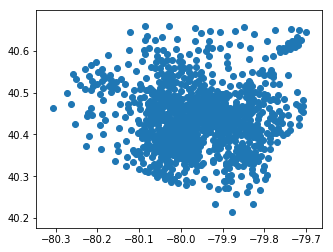

In [116]:
blkgrps_cent_gj.plot()

In [147]:
# Load in PghOutbuff geojson, which is the outline of Pittsburgh buffered out a ways to be able to do within spatial joins
pgh_outbuff_gj= gpd.read_file('allegheny_county/pgh/PghOutbuffExact.geojson')

In [148]:
pgh_outbuff_gj

city_name  \
0  Pittsburgh   
1  Pittsburgh   
2  Pittsburgh   
3  Pittsburgh   
4  Pittsburgh   
5  Pittsburgh   
6  Pittsburgh   

                                                                                                                                                                                                                                                                                                      geometry  
0  POLYGON ((-79.9351952910752 40.3964746147334, -79.9351698033079 40.3964790157999, -79.9350930864735 40.3964843870943, -79.9350311030198 40.3964698829461, -79.9349952424255 40.3964705614509, -79.9348680571011 40.3965004019801, -79.93478697835479 40.3965293701019, -79.93452215449371 40.39659330940...  
1  POLYGON ((-80.00410666529559 40.3740446208956, -80.0054382971671 40.3747975099598, -80.00654724573209 40.3750015624404, -80.0064694316291 40.3750954579545, -80.0064037751611 40.3751821651713, -80.0063015519577 40.3752859767485, -80.0061944853171 40.3754160978575, -80.0061131894105 40.37554013757...  
2  POLYGON ((-79.8840416957775 40.4824565982262, -79.8841734642882 40.4819238393538, -79.8847027214546 40.4794951373683, -79.8847379665052 40.4794115864348, -79.88476694697179 40.47934013958981, -79.8848006123106 40.4792483948856, -79.8848401246038 40.4791620634937, -79.8849023678074 40.47905908367...  
3  POLYGON ((-79.9015036953717 40.487439836265, -79.90154815330089 40.4887325946161, -79.8995009237899 40.4883170760919, -79.897574614717 40.4878547852299, -79.8969624706242 40.4916359808514, -79.8968626015001 40.4925407956931, -79.8962176828432 40.4924440661481, -79.8955857071219 40.4923445687498,...  
4  POLYGON ((-80.0410514221517 40.4639492782794, -80.04079577715372 40.4636814082809, -80.0404825658768 40.4633578549419, -80.040373148203 40.4632234088046, -80.04029582709779 40.4631260125602, -80.0398302532076 40.4624831874082, -80.03984912841671 40.4622315921044, -80.03981782420711 40.4621867210...  
5  POLYGON ((-79.9745291224836 40.4662843105115, -79.9746156023345 40.4661374478117, -79.974693285776 40.466006413233, -79.97491833512311 40.4656533221017, -79.9751230500696 40.4653618314687, -79.97544294529982 40.4650026425043, -79.9756660466886 40.4647036799589, -79.975778574831 40.4645556039604,...  
6  POLYGON ((-80.0514766052797 40.483499667399, -80.0498211711549 40.484796757965, -80.0501778416585 40.4851078422544, -80.0501943535244 40.485196004252, -80.0485861613752 40.4864277439927, -80.048150229592 40.4864506577934, -80.0478797978186 40.4863465654292, -80.04686158710599 40.4871545751779, -...

In [149]:
pgh_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, pgh_outbuff_gj, how="inner", op='within')
pgh_blkgroups_gj=pgh_blkgroups_gj.set_index('GEOID10')
pgh_blkgroups_gj

geometry  index_right  \
GEOID10                                                                   
420030405001   POINT (-79.9542331702762 40.44068048140166)            2   
420030404001  POINT (-79.94839321625416 40.44584078497987)            2   
420030402002  POINT (-79.96261070464578 40.44124374229452)            2   
420030305002  POINT (-79.98134756700156 40.44038713787921)            2   
420030305001  POINT (-79.98557267712718 40.44447627770392)            2   
420030203001   POINT (-79.98149985487389 40.4542542337612)            2   
420030201004  POINT (-79.98921213414241 40.44067769199005)            2   
420039810001  POINT (-79.94887584764464 40.47308211820581)            2   
420030201003  POINT (-79.99910473385363 40.44136873803838)            2   
420030201002   POINT (-80.00425689406254 40.4434730168507)            2   
420030201001  POINT (-80.00672480955386 40.43963007918039)            2   
420030103002  POINT (-79.99039869170446 40.43690040796075)            2   
420030103001  POINT (-79.98489010911516 40.43434930770278)            2   
420035629001  POINT (-79.94854381987861 40.41083453026457)            2   
420035619002  POINT (-79.89247838824866 40.46703213977975)            2   
420031306001  POINT (-79.88172253980282 40.45219247732992)            2   
420030409003  POINT (-79.95180130685355 40.43080743232132)            2   
420035623005  POINT (-79.93691201099415 40.41429571307498)            2   
420035623003  POINT (-79.93143103609643 40.41258052282817)            2   
420030201005  POINT (-79.99655112628068 40.43799279138322)            2   
420031517004  POINT (-79.93539929325583 40.42163271161279)            2   
420031517003   POINT (-79.93852722727411 40.4225131411042)            2   
420031517002  POINT (-79.93451957061397 40.42726496444745)            2   
420031517001  POINT (-79.92777663184705 40.42284317659258)            2   
420031516003  POINT (-79.94484614040459 40.42276615214166)            2   
420031516001   POINT (-79.94141428377621 40.4231224228341)            2   
420031414003  POINT (-79.91857332049838 40.42660342448738)            2   
420031414001  POINT (-79.92282569433453 40.42143990967239)            2   
420031413003  POINT (-79.92533626116546 40.43204534497225)            2   
420030103003  POINT (-79.98373466857225 40.43687838978125)            2   
...                                                    ...          ...   
420033204002  POINT (-79.99339477852735 40.38701318082626)            1   
420033206001  POINT (-80.00684446062253 40.39712950653624)            1   
420033207001  POINT (-80.00095052306544 40.38572383776076)            1   
420033207002   POINT (-79.9993596575145 40.37835033249937)            1   
420035631003  POINT (-80.03448022457665 40.42706924752226)            1   
420031920001  POINT (-80.02170445366258 40.40585720055733)            1   
420034810002  POINT (-79.98412745806517 40.41205014031699)            1   
420033206002  POINT (-80.00366745325351 40.39267920013398)            1   
420035628002   POINT (-80.0658035022757 40.42692457280716)            1   
420034810003  POINT (-79.98840627930947 40.41003380201636)            1   
420034810001  POINT (-79.98515400419751 40.41588496459507)            1   
420034810004  POINT (-79.98517512157321 40.40779816377491)            1   
420035628001  POINT (-80.07457192323481 40.42022219555205)            1   
420035630001  POINT (-80.08478115378117 40.45078169794654)            1   
420031608002  POINT (-79.96564205337505 40.42161244521922)            1   
420031608003  POINT (-79.96878258211984 40.41925641942294)            1   
420031608004  POINT (-79.97593911289918 40.42078156974876)            1   
420031609001  POINT (-79.96895118205863 40.42955816086297)            1   
420031609002  POINT (-79.96193361789165 40.42251763959891)            1   
420035625001    POINT (-80.052257798995 40.46067123876791)            1   
420039800001  POINT (-79.89240528029555 40.48825403272297)            3   


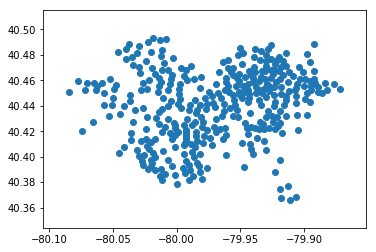

In [150]:
pgh_blkgroups_gj.plot()

# Deal with special case of MtOliverBoro

In [126]:
mob_gj = gpd.read_file('allegheny_county/pgh/MtOliverBoro.geojson')

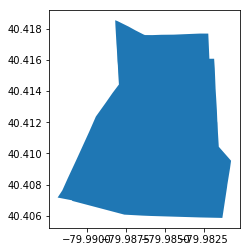

In [127]:
mob_gj.plot()

In [128]:
mob_blkgroups_gj = gpd.sjoin(blkgrps_cent_gj, mob_gj, how="inner", op='within')
mob_blkgroups_gj=mob_blkgroups_gj.set_index('GEOID10')
mob_blkgroups_gj

geometry  index_right  \
GEOID10                                                                   
420034810002  POINT (-79.98412745806517 40.41205014031699)            0   
420034810003  POINT (-79.98840627930947 40.41003380201636)            0   
420034810001  POINT (-79.98515400419751 40.41588496459507)            0   
420034810004  POINT (-79.98517512157321 40.40779816377491)            0   

                           Name  \
GEOID10                           
420034810002  Mount Oliver Boro   
420034810003  Mount Oliver Boro   
420034810001  Mount Oliver Boro   
420034810004  Mount Oliver Boro   

                                                                                                                                                                                                                                                                                                              description  \
GEOID10                                                                                                                                                                                                                                                                                                                     
420034810002  <html xmlns:fo="http://www.w3.org/1999/XSL/Format" xmlns:msxsl="urn:schemas-microsoft-com:xslt">\n\n<head>\n\n<META http-equiv="Content-Type" content="text/html">\n\n</head>\n\n<body style="margin:0px 0px 0px 0px;overflow:auto;background:#FFFFFF;">\n\n<table style="font-family:Arial,Verdana,Time...   
420034810003  <html xmlns:fo="http://www.w3.org/1999/XSL/Format" xmlns:msxsl="urn:schemas-microsoft-com:xslt">\n\n<head>\n\n<META http-equiv="Content-Type" content="text/html">\n\n</head>\n\n<body style="margin:0px 0px 0px 0px;overflow:auto;background:#FFFFFF;">\n\n<table style="font-family:Arial,Verdana,Time...   
420034810001  <html xmlns:fo="http://www.w3.org/1999/XSL/Format" xmlns:msxsl="urn:schemas-microsoft-com:xslt">\n\n<head>\n\n<META http-equiv="Content-Type" content="text/html">\n\n</head>\n\n<body style="margin:0px 0px 0px 0px;overflow:auto;background:#FFFFFF;">\n\n<table style="font-family:Arial,Verdana,Time...   
420034810004  <html xmlns:fo="http://www.w3.org/1999/XSL/Format" xmlns:msxsl="urn:schemas-microsoft-com:xslt">\n\n<head>\n\n<META http-equiv="Content-Type" content="text/html">\n\n</head>\n\n<body style="margin:0px 0px 0px 0px;overflow:auto;background:#FFFFFF;">\n\n<table style="font-family:Arial,Verdana,Time...   

              tessellate  extrude  visibility snippet  
GEOID10                                                
420034810002          -1        0           0          
420034810003          -1        0           0          
420034810001          -1        0           0          
420034810004          -1        0           0

# Create a function that takes a blockgroup ID and returns True if it's in Pittsburgh

In [157]:
# The centroid inclusion fails in a few places.  Fix those up here.
pgh_add_blkgrps = ['420039809001']
pgh_sub_blkgrps = ['420034803001','420034790001','420034825001']

def blkgrp_in_pgh(blkgroup_id):
    if blkgroup_id in pgh_add_blkgrps:
        return True
    if blkgroup_id in pgh_sub_blkgrps:
        return False
    
    if blkgroup_id in mob_blkgroups_gj.index:
        return False
    if blkgroup_id in pgh_blkgroups_gj.index:
        return True
    return False

In [158]:
blkgrp_in_pgh('420034810003')

False

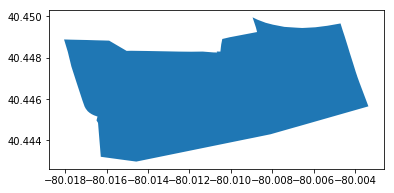

In [159]:
blkgrps_gj[blkgrps_gj.GEOID10.str.contains('420039812001')].plot()

In [160]:
blkgrps_gj['in_pgh'] = blkgrps_gj['GEOID10'].apply(blkgrp_in_pgh)

In [161]:
blkgrps_in_pgh_gj= blkgrps_gj[blkgrps_gj.in_pgh==True].copy()

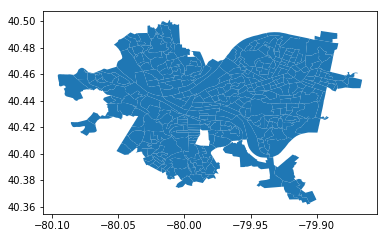

In [162]:
blkgrps_in_pgh_gj.plot()

In [163]:
# Write out the blockgrps_in_pgh_gj  geometry as a geojson file
blkgrps_in_pgh_gj.reset_index()[['GEOID10','geometry']].to_file('allegheny_county/pgh/BlkgrpsInPgh.geojson', driver="GeoJSON")


In [164]:
binarize_geojson_outlines('allegheny_county/pgh/BlkgrpsInPgh.geojson', 
                          'allegheny_county/pgh/BlkgrpsInPgh.bin')

Read 355 features from allegheny_county/pgh/BlkgrpsInPgh.geojson
45726 segments
Created allegheny_county/pgh/BlkgrpsInPgh.bin (45726 segments)


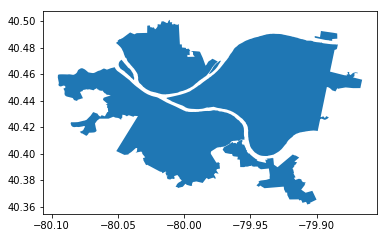

In [156]:
pgh_outbuff_gj.plot()

In [99]:
# Fix up names that don't quite match up before merge
pdb_nhbd['HOOD'] = pdb_nhbd['HOOD'].str.replace('St. Clair','Saint Clair')
pdb_nhbd['HOOD'] = pdb_nhbd['HOOD'].str.replace('Central Business District','Golden Triangle')
pdb_nhbd['HOOD'] = pdb_nhbd['HOOD'].str.replace('Central North Side','Central Northside')
pdb_nhbd['HOOD'] = pdb_nhbd['HOOD'].str.replace('Northview Heights','Northview Height')
pdb_nhbd['HOOD'] = pdb_nhbd['HOOD'].str.replace('Mt. Oliver','Mount Oliver Neighborhood')

In [100]:
# Merge nhbd_pgh_gj pdb_nhbd so we can get just Pittsburgh, see if they line up properly
pdb_nhbd_merge = pd.merge(pdb_nhbd,nhbd_pgh_gj,left_on='HOOD',right_on='Name',sort=False,how='outer',
                         suffixes=('_pdb', '_pgh'), copy=True, indicator=False,
                         validate=None)

In [165]:
pdb_nhbd_merge['in_pgh'] = pdb_nhbd_merge['GIDBG'].apply(blkgrp_in_pgh)

In [166]:
pdb_nhbd_merge[['GIDBG','HOOD','Name','city_name','in_pgh','POP','Tot_Population_CEN_2010','Low_Response_Score']]

GIDBG              HOOD              Name   city_name  in_pgh  \
0    420030103001             Bluff             Bluff  Pittsburgh    True   
1    420030103002             Bluff             Bluff  Pittsburgh    True   
2    420030103003             Bluff             Bluff  Pittsburgh    True   
3    420030103004             Bluff             Bluff  Pittsburgh    True   
4    420030201001   Golden Triangle   Golden Triangle  Pittsburgh    True   
5    420030201002   Golden Triangle   Golden Triangle  Pittsburgh    True   
6    420030201003   Golden Triangle   Golden Triangle  Pittsburgh    True   
7    420030201004   Golden Triangle   Golden Triangle  Pittsburgh    True   
8    420030201005   Golden Triangle   Golden Triangle  Pittsburgh    True   
9    420030201006   Golden Triangle   Golden Triangle  Pittsburgh    True   
10   420030203001    Strip District    Strip District  Pittsburgh    True   
11   420030305001  Crawford-Roberts  Crawford-Roberts  Pittsburgh    True   
12   420030305002  Crawford-Roberts  Crawford-Roberts  Pittsburgh    True   
13   420030402001      West Oakland      West Oakland  Pittsburgh    True   
14   420030402002      West Oakland      West Oakland  Pittsburgh    True   
15   420030404001     North Oakland     North Oakland  Pittsburgh    True   
16   420030404002     North Oakland     North Oakland  Pittsburgh    True   
17   420035620001     North Oakland     North Oakland  Pittsburgh    True   
18   420035620002     North Oakland     North Oakland  Pittsburgh    True   
19   420035620003     North Oakland     North Oakland  Pittsburgh    True   
20   420039822001     North Oakland     North Oakland  Pittsburgh    True   
21   420030405001   Central Oakland   Central Oakland  Pittsburgh    True   
22   420030405002   Central Oakland   Central Oakland  Pittsburgh    True   
23   420030406001   Central Oakland   Central Oakland  Pittsburgh    True   
24   420030409001     South Oakland     South Oakland  Pittsburgh    True   
25   420030409002     South Oakland     South Oakland  Pittsburgh    True   
26   420030409003     South Oakland     South Oakland  Pittsburgh    True   
27   420039808001     South Oakland     South Oakland  Pittsburgh    True   
28   420030501001       Middle Hill       Middle Hill  Pittsburgh    True   
29   420030501002       Middle Hill       Middle Hill  Pittsburgh    True   
..            ...               ...               ...         ...     ...   
325  420035629003         Hazelwood         Hazelwood  Pittsburgh    True   
326  420035623002        Glen Hazel        Glen Hazel  Pittsburgh    True   
327  420035624001           Bon Air           Bon Air  Pittsburgh    True   
328  420035624002       Beltzhoover       Beltzhoover  Pittsburgh    True   
329  420035624003       Beltzhoover       Beltzhoover  Pittsburgh    True   
330  420035624004       Beltzhoover       Beltzhoover  Pittsburgh    True   
331  420035624005       Beltzhoover       Beltzhoover  Pittsburgh    True   
332  420035625001            Esplen            Esplen  Pittsburgh    True   
333  420035626001          West End          West End  Pittsburgh    True   
334  420035626002           Elliott           Elliott  Pittsburgh    True   
335  420035626003           Elliott           Elliott  Pittsburgh    True   
336  420035626004           Elliott           Elliott  Pittsburgh    True   
337  420035627001    Allegheny West    Allegheny West  Pittsburgh    True   
338  420035627002  Allegheny Center  Allegheny Center  Pittsburgh    True   
339  420035628001     East Carnegie     East Carnegie  Pittsburgh    True   
340  420035628002           Oakwood           Oakwood  Pittsburgh    True   
341  420035629002              Hays              Hays  Pittsburgh    True   
342  420035630001         Fairywood         Fairywood  Pittsburgh    True   
343  420035630002           Windgap           Windgap  Pittsburgh    True   
344  420035630003           Windgap           Windgap  Pittsburgh    True   
345  420

In [167]:
# Find which ones aren't in Pittsburgh
pdb_nhbd_merge[pdb_nhbd_merge.in_pgh==False][['GIDBG','HOOD','Name','city_name','in_pgh','POP','Tot_Population_CEN_2010','Low_Response_Score']]

Empty DataFrame
Columns: [GIDBG, HOOD, Name, city_name, in_pgh, POP, Tot_Population_CEN_2010, Low_Response_Score]
Index: []

In [73]:
# Find which ones don't match up
pdb_nhbd_merge[(~pd.isna(pdb_nhbd_merge.HOOD)) & (pd.isna(pdb_nhbd_merge.Name))][['GIDBG','HOOD','Name','city_name','POP','Tot_Population_CEN_2010','Low_Response_Score']]

Empty DataFrame
Columns: [GIDBG, HOOD, Name, city_name, POP, Tot_Population_CEN_2010, Low_Response_Score]
Index: []

In [74]:
# It's fine that Brunots Island isn't reflected in HOOD -- it is contained in one of the census block groups that overlaps the north side
pdb_nhbd_merge[(pd.isna(pdb_nhbd_merge.HOOD)) & (~pd.isna(pdb_nhbd_merge.Name))][['GIDBG','HOOD','Name','city_name','POP','Tot_Population_CEN_2010','Low_Response_Score']]

GIDBG HOOD            Name   city_name  POP  Tot_Population_CEN_2010  \
355   NaN  NaN  Brunots Island  Pittsburgh  NaN                      NaN   

     Low_Response_Score  
355                 NaN

In [102]:
# Get rid of Brunots Island and set other Low_Response_Scores that are NaN to 0
pdb_nhbd_merge=pdb_nhbd_merge[~pd.isna(pdb_nhbd_merge.GIDBG)].copy()

In [106]:
# These appear to either be uninhabited or correctional facilities
lrs_nan = pdb_nhbd_merge[(pd.isna(pdb_nhbd_merge.Low_Response_Score))][['GIDBG','HOOD','city_name','Tot_Population_CEN_2010','Low_Response_Score']]
lrs_nan

GIDBG                      HOOD   city_name  \
0    420030103001                     Bluff  Pittsburgh   
1    420030103002                     Bluff  Pittsburgh   
27   420039808001             South Oakland  Pittsburgh   
73   420039810001     Central Lawrenceville  Pittsburgh   
110  420039800001  Lincoln-Lemington-Belmar  Pittsburgh   
134  420031401003       Squirrel Hill North  Pittsburgh   
163  420039803001       Squirrel Hill South  Pittsburgh   
255  420039804001               Perry North  Pittsburgh   
278  420039809001        Marshall-Shadeland  Pittsburgh   
350  420039812001               North Shore  Pittsburgh   

     Tot_Population_CEN_2010  Low_Response_Score  
0                     2594.0                 NaN  
1                     3336.0                 NaN  
27                       0.0                 NaN  
73                       4.0                 NaN  
110                    540.0                 NaN  
134                    527.0                 NaN  
163                      1.0                 NaN  
255                     21.0                 NaN  
278                   1797.0                 NaN  
350                      0.0                 NaN

In [108]:
pdb_nhbd_merge['Low_Response_Score']=pdb_nhbd_merge['Low_Response_Score'].fillna(0)

In [109]:
pdb_nhbd_merge['undercount'] = pdb_nhbd_merge['Tot_Population_CEN_2010']*pdb_nhbd_merge['Low_Response_Score']/100.0

In [111]:
lrs_all = pdb_nhbd_merge[['GIDBG','HOOD','city_name','Tot_Population_CEN_2010','Low_Response_Score','undercount']]

In [114]:
xls_writer = pd.ExcelWriter('allegheny_county/pgh/census_2020_pgh_est.xls')
lrs_all.to_excel(xls_writer,'LRS All Pittsburgh')
lrs_nan.to_excel(xls_writer,'LRS NaN')

xls_writer.save()

In [95]:
round(pdb_nhbd_merge['Tot_Population_CEN_2010'].sum())

305704.0

In [94]:
round(pdb_nhbd_merge['undercount'].sum())

63105.0

In [168]:
# Crosscheck to see if we lost anything doing the neighborhood merge
ac_data['in_pgh'] = ac_data['GIDBG'].apply(blkgrp_in_pgh)
ac_in_pgh=ac_data[ac_data['in_pgh']==True]

In [169]:
# Matches if answer is 305704.0
round(ac_in_pgh['Tot_Population_CEN_2010'].sum())

305704.0

In [75]:
pdb_nhbd_merge_gj = gpd.GeoDataFrame(pdb_nhbd_merge, geometry=pdb_nhbd_merge.geometry, crs={'init': 'epsg:4326'})

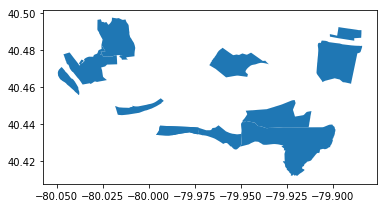

In [78]:
pdb_nhbd_merge_gj[(pd.isna(pdb_nhbd_merge.Low_Response_Score))].plot()

# Create CSV for choropleth

In [47]:
# Write out CSV for doing a blockgroup choropleth
def write_pdb_csv(pdb_data, column_name, out_path):
    date_range = range(2017, 2019)
    out = open(out_path, 'w')
    # Write out header row.  First column doesn't have a column heading, next two are lat, lon, then each year
    out.write("GEOID10,%s\n" % (",".join(map(str,date_range))))
    
    for r in range(len(ac_data)):
        blockgroup = str(ac_data['GIDBG'][r])
        val=0
        if(not pd.isnull(ac_data[column_name][r])):
            val = ac_data[column_name][r]

        out_data=[blockgroup]
        
        for year in date_range:
            out_data.append(val)
            
        out.write('%s\n' % (",".join(map(str,out_data))))
    out.close()

In [48]:
write_pdb_csv(ac_data, 'Low_Response_Score', 'allegheny_county/lrs_2018.csv')

### Read 2010 block geoids and 2010 block populations

In [7]:
block_populations = numpy.load('columncache/census2010_block2010/p001001.numpy')
print 'block_populations has', sum(block_populations), 'total people'

block_populations has 308745538 total people


In [8]:
# block_geoids_2010 = [row[0] for row in query_psql("SELECT geoid2010 FROM sf1_2010_block_p001 order by blockidx2010")]
block_geoids_2010 = json.load(open('block_geoids_2010.json'))
print 'There are', len(block_geoids_2010), 'blocks'

assert(len(block_geoids_2010) + 1 == len(block_populations))

There are 11078297 blocks


### Compute 2010 population by tract and block indices from tract

In [9]:
blockgroup_populations = {}
blockgroup_block_indexes = {}

for block_index_minus_one, block_geoid in enumerate(block_geoids_2010):
    block_index = block_index_minus_one + 1
    blockgroup_name = block_geoid[0:12] # SSCCCTTTTTTG
    if blockgroup_name not in blockgroup_populations:
        blockgroup_populations[blockgroup_name] = 0
        blockgroup_block_indexes[blockgroup_name] = []
    blockgroup_populations[blockgroup_name] += block_populations[block_index]
    blockgroup_block_indexes[blockgroup_name].append(block_index)

print 'There are', len(blockgroup_populations), 'blockgroups'
print 'blockgroup_populations has', sum(blockgroup_populations.values()), 'people'

There are 217740 blockgroups
blockgroup_populations has 308745538 people


### Interpolate and write columns for data file

In [10]:
output_col = numpy.zeros(block_populations.size, dtype=numpy.float32)
len(output_col)

11078298

In [11]:
!mkdir columncache/PDB2018

In [50]:
for r in range(len(ac_data)):
    blockgroup = str(ac_data['GIDBG'][r])
    # LRS is a percentage of the population that's expected not to respond * 100 (so 22.5% = 22.5)
    pct_lrs=0
    if(not pd.isnull(ac_data['Low_Response_Score'][r])):
        pct_lrs = ac_data['Low_Response_Score'][r]/100.0
    print '%s has ~%f%% of the people missing' % (blockgroup, pct_lrs*100.0)
    for block_index in blockgroup_block_indexes[blockgroup]:
        if block_populations[block_index]:
            interp = pct_lrs * float(block_populations[block_index])
            output_col[block_index] = interp
            print '  assigning %s with %.2f people' % (block_geoids_2010[block_index - 1], interp)
            total_assigned = total_assigned + round(interp)
output_col_path = 'columncache/PDB2018/LRS.float32'
output_col.tofile(output_col_path + '.tmp')
os.rename(output_col_path + '.tmp', output_col_path)
sys.stdout.write('Created %s with sum %f\n' % (output_col_path, output_col.sum()))


420030103001 has ~0.000000% of the people missing
  assigning 420030103001007 with 0.00 people
420030103002 has ~0.000000% of the people missing
  assigning 420030103002002 with 0.00 people
  assigning 420030103002015 with 0.00 people
  assigning 420030103002016 with 0.00 people
420030103003 has ~22.900000% of the people missing
  assigning 420030103003001 with 0.23 people
  assigning 420030103003002 with 0.23 people
  assigning 420030103003003 with 7.33 people
  assigning 420030103003006 with 3.21 people
  assigning 420030103003007 with 7.33 people
  assigning 420030103003008 with 9.16 people
  assigning 420030103003009 with 5.27 people
  assigning 420030103003010 with 2.29 people
  assigning 420030103003012 with 7.79 people
  assigning 420030103003015 with 11.45 people
  assigning 420030103003016 with 10.08 people
  assigning 420030103003017 with 12.82 people
  assigning 420030103003018 with 3.66 people
420030103004 has ~26.800000% of the people missing
  assigning 420030103004002 wi

  assigning 420030901001004 with 3.96 people
  assigning 420030901001005 with 6.73 people
  assigning 420030901001007 with 0.59 people
  assigning 420030901001008 with 11.09 people
  assigning 420030901001009 with 7.13 people
  assigning 420030901001010 with 5.74 people
  assigning 420030901001011 with 4.36 people
  assigning 420030901001012 with 4.16 people
  assigning 420030901001013 with 25.15 people
  assigning 420030901001014 with 7.33 people
  assigning 420030901001016 with 0.40 people
  assigning 420030901001017 with 6.93 people
  assigning 420030901001018 with 1.58 people
  assigning 420030901001019 with 4.75 people
  assigning 420030901001020 with 13.66 people
  assigning 420030901001021 with 2.38 people
  assigning 420030901001022 with 4.16 people
  assigning 420030901001023 with 0.20 people
  assigning 420030901001024 with 8.71 people
  assigning 420030901001025 with 6.93 people
  assigning 420030901001026 with 2.57 people
  assigning 420030901001027 with 3.96 people
  assig

  assigning 420031609002021 with 16.50 people
  assigning 420031609002022 with 16.50 people
  assigning 420031609002023 with 13.60 people
  assigning 420031609002024 with 11.37 people
  assigning 420031609002025 with 7.58 people
  assigning 420031609002026 with 22.52 people
  assigning 420031609002027 with 15.39 people
  assigning 420031609002028 with 12.71 people
  assigning 420031609002029 with 14.94 people
  assigning 420031609002030 with 0.45 people
  assigning 420031609002031 with 12.04 people
  assigning 420031609002032 with 7.80 people
  assigning 420031609002033 with 11.82 people
  assigning 420031609002036 with 14.50 people
  assigning 420031609002037 with 1.11 people
  assigning 420031609002042 with 7.36 people
  assigning 420031609002043 with 3.35 people
  assigning 420031609002044 with 9.37 people
  assigning 420031609002045 with 9.37 people
  assigning 420031609002048 with 8.70 people
  assigning 420031609002049 with 8.70 people
  assigning 420031609002050 with 29.21 peopl

  assigning 420032022002003 with 1.20 people
  assigning 420032022002004 with 3.25 people
  assigning 420032022002005 with 4.79 people
  assigning 420032022002006 with 1.54 people
  assigning 420032022002007 with 2.05 people
  assigning 420032022002008 with 2.91 people
  assigning 420032022002009 with 3.25 people
  assigning 420032022002010 with 4.62 people
  assigning 420032022002011 with 5.99 people
  assigning 420032022002012 with 3.59 people
  assigning 420032022002013 with 4.28 people
  assigning 420032022002014 with 3.08 people
  assigning 420032022002015 with 2.05 people
  assigning 420032022002016 with 0.68 people
  assigning 420032022002017 with 5.47 people
  assigning 420032022002018 with 4.45 people
  assigning 420032022002019 with 2.39 people
  assigning 420032022002020 with 2.91 people
  assigning 420032022002021 with 1.54 people
  assigning 420032022002023 with 3.42 people
  assigning 420032022002024 with 3.42 people
  assigning 420032022002025 with 3.59 people
  assignin

  assigning 420033207001032 with 13.58 people
  assigning 420033207001033 with 2.24 people
  assigning 420033207001034 with 0.84 people
  assigning 420033207001035 with 0.28 people
  assigning 420033207001036 with 0.56 people
  assigning 420033207001037 with 2.80 people
  assigning 420033207001038 with 5.60 people
  assigning 420033207001039 with 1.26 people
  assigning 420033207001040 with 0.70 people
  assigning 420033207001041 with 2.80 people
  assigning 420033207001042 with 2.94 people
420033207002 has ~17.400000% of the people missing
  assigning 420033207002000 with 0.52 people
  assigning 420033207002002 with 1.22 people
  assigning 420033207002003 with 4.18 people
  assigning 420033207002004 with 2.09 people
  assigning 420033207002005 with 2.96 people
  assigning 420033207002006 with 32.54 people
  assigning 420033207002007 with 15.31 people
  assigning 420033207002010 with 4.52 people
  assigning 420033207002013 with 4.35 people
  assigning 420033207002014 with 7.83 people
 

  assigning 420034090002016 with 0.18 people
  assigning 420034090002017 with 1.61 people
  assigning 420034090002018 with 0.33 people
  assigning 420034090002019 with 0.18 people
  assigning 420034090002021 with 1.47 people
  assigning 420034090002022 with 0.04 people
  assigning 420034090002025 with 0.36 people
  assigning 420034090002028 with 0.21 people
  assigning 420034090002029 with 1.44 people
  assigning 420034090002030 with 0.05 people
  assigning 420034090002032 with 0.03 people
420034090003 has ~10.100000% of the people missing
  assigning 420034090003001 with 0.30 people
  assigning 420034090003003 with 0.20 people
  assigning 420034090003004 with 19.19 people
  assigning 420034090003006 with 3.84 people
  assigning 420034090003007 with 0.61 people
  assigning 420034090003008 with 44.84 people
  assigning 420034090003010 with 23.53 people
  assigning 420034090003011 with 6.56 people
  assigning 420034090003012 with 13.23 people
  assigning 420034090003013 with 3.23 people


  assigning 420034250004042 with 10.16 people
  assigning 420034250004043 with 15.71 people
  assigning 420034250004044 with 4.62 people
  assigning 420034250004048 with 3.93 people
420034263001 has ~9.400000% of the people missing
  assigning 420034263001001 with 2.35 people
  assigning 420034263001002 with 3.48 people
  assigning 420034263001003 with 2.82 people
  assigning 420034263001004 with 21.34 people
  assigning 420034263001005 with 3.20 people
  assigning 420034263001006 with 2.91 people
  assigning 420034263001007 with 2.26 people
  assigning 420034263001008 with 3.85 people
  assigning 420034263001011 with 5.45 people
  assigning 420034263001013 with 6.49 people
  assigning 420034263001014 with 3.95 people
  assigning 420034263001015 with 5.45 people
  assigning 420034263001016 with 17.01 people
  assigning 420034263001018 with 1.32 people
  assigning 420034263001020 with 6.77 people
  assigning 420034263001021 with 9.49 people
  assigning 420034263001022 with 2.16 people
 

  assigning 420034302004008 with 0.00 people
  assigning 420034302004009 with 0.00 people
  assigning 420034302004010 with 0.00 people
  assigning 420034302004011 with 0.00 people
  assigning 420034302004012 with 0.00 people
420034302005 has ~16.900000% of the people missing
  assigning 420034302005000 with 18.42 people
  assigning 420034302005001 with 12.17 people
  assigning 420034302005002 with 5.07 people
  assigning 420034302005003 with 8.62 people
  assigning 420034302005004 with 11.15 people
  assigning 420034302005005 with 6.59 people
  assigning 420034302005006 with 5.24 people
  assigning 420034302005007 with 6.25 people
  assigning 420034302005008 with 15.38 people
  assigning 420034302005009 with 2.87 people
  assigning 420034302005010 with 4.73 people
  assigning 420034302005011 with 1.18 people
  assigning 420034302005012 with 4.22 people
  assigning 420034302005013 with 4.06 people
  assigning 420034302005014 with 8.62 people
  assigning 420034302005015 with 13.35 people

  assigning 420034591011031 with 13.42 people
  assigning 420034591011032 with 7.33 people
420034591021 has ~7.700000% of the people missing
  assigning 420034591021000 with 19.17 people
  assigning 420034591021001 with 10.16 people
  assigning 420034591021002 with 7.31 people
  assigning 420034591021003 with 8.78 people
  assigning 420034591021004 with 63.91 people
  assigning 420034591021005 with 1.31 people
  assigning 420034591021006 with 2.62 people
  assigning 420034591021007 with 8.55 people
  assigning 420034591021008 with 3.08 people
  assigning 420034591021009 with 13.32 people
  assigning 420034591021010 with 5.39 people
  assigning 420034591021011 with 3.23 people
  assigning 420034591021014 with 2.31 people
  assigning 420034591021015 with 3.46 people
  assigning 420034591021016 with 7.78 people
420034591022 has ~9.700000% of the people missing
  assigning 420034591022000 with 52.86 people
  assigning 420034591022002 with 34.82 people
  assigning 420034591022003 with 1.36 

  assigning 420034689002018 with 9.73 people
  assigning 420034689002019 with 0.42 people
  assigning 420034689002020 with 7.23 people
  assigning 420034689002021 with 19.46 people
  assigning 420034689002022 with 3.34 people
  assigning 420034689002023 with 2.36 people
  assigning 420034689002024 with 14.04 people
  assigning 420034689002025 with 2.92 people
  assigning 420034689002026 with 7.23 people
  assigning 420034689002027 with 5.56 people
  assigning 420034689002029 with 4.03 people
  assigning 420034689002030 with 3.89 people
  assigning 420034689002031 with 1.67 people
420034689003 has ~27.200000% of the people missing
  assigning 420034689003000 with 2.45 people
  assigning 420034689003002 with 18.22 people
  assigning 420034689003003 with 6.53 people
  assigning 420034689003005 with 2.72 people
  assigning 420034689003006 with 0.27 people
  assigning 420034689003007 with 7.62 people
  assigning 420034689003009 with 0.82 people
  assigning 420034689003012 with 8.70 people
 

  assigning 420034736011007 with 0.28 people
  assigning 420034736011008 with 0.87 people
  assigning 420034736011010 with 1.41 people
  assigning 420034736011012 with 0.16 people
420034736012 has ~13.200000% of the people missing
  assigning 420034736012000 with 116.69 people
  assigning 420034736012001 with 3.70 people
  assigning 420034736012003 with 7.52 people
  assigning 420034736012004 with 54.78 people
  assigning 420034736012005 with 5.94 people
  assigning 420034736012006 with 7.92 people
  assigning 420034736012007 with 3.96 people
420034736013 has ~14.500000% of the people missing
  assigning 420034736013000 with 30.01 people
  assigning 420034736013001 with 10.58 people
  assigning 420034736013002 with 18.27 people
  assigning 420034736013003 with 18.12 people
  assigning 420034736013004 with 19.43 people
  assigning 420034736013005 with 15.37 people
  assigning 420034736013006 with 11.02 people
  assigning 420034736013007 with 14.35 people
  assigning 420034736013008 with

  assigning 420034803003012 with 3.12 people
  assigning 420034803003013 with 1.01 people
  assigning 420034803003014 with 4.91 people
420034803004 has ~12.000000% of the people missing
  assigning 420034803004000 with 4.68 people
  assigning 420034803004001 with 11.16 people
  assigning 420034803004002 with 6.96 people
  assigning 420034803004003 with 2.64 people
  assigning 420034803004004 with 5.28 people
  assigning 420034803004005 with 4.68 people
  assigning 420034803004006 with 6.60 people
  assigning 420034803004007 with 12.84 people
  assigning 420034803004008 with 3.48 people
  assigning 420034803004009 with 2.76 people
  assigning 420034803004010 with 2.64 people
  assigning 420034803004011 with 4.68 people
  assigning 420034803004012 with 9.48 people
  assigning 420034803004013 with 3.00 people
  assigning 420034803004014 with 4.80 people
  assigning 420034803004015 with 4.20 people
  assigning 420034803004016 with 5.04 people
420034804001 has ~7.600000% of the people missi

  assigning 420034940001051 with 2.24 people
  assigning 420034940001052 with 0.75 people
  assigning 420034940001053 with 9.72 people
  assigning 420034940001054 with 3.18 people
  assigning 420034940001056 with 2.24 people
  assigning 420034940001057 with 2.06 people
  assigning 420034940001058 with 7.67 people
  assigning 420034940001059 with 2.62 people
  assigning 420034940001060 with 1.68 people
  assigning 420034940001061 with 5.24 people
  assigning 420034940001062 with 5.24 people
  assigning 420034940001064 with 2.99 people
  assigning 420034940001065 with 2.43 people
  assigning 420034940001066 with 11.41 people
  assigning 420034940001067 with 2.81 people
  assigning 420034940001068 with 1.87 people
  assigning 420034940001069 with 1.87 people
  assigning 420034940001070 with 1.68 people
  assigning 420034940001071 with 0.75 people
  assigning 420034940001073 with 0.94 people
  assigning 420034940001074 with 1.31 people
  assigning 420034940001075 with 1.12 people
  assigni

  assigning 420035138003039 with 0.90 people
  assigning 420035138003040 with 2.02 people
  assigning 420035138003043 with 3.36 people
  assigning 420035138003044 with 1.79 people
  assigning 420035138003045 with 7.17 people
  assigning 420035138003048 with 1.12 people
  assigning 420035138003049 with 5.38 people
  assigning 420035138003053 with 1.57 people
  assigning 420035138003054 with 0.45 people
  assigning 420035138003056 with 0.22 people
  assigning 420035138003057 with 0.45 people
420035140001 has ~25.800000% of the people missing
  assigning 420035140001000 with 65.02 people
  assigning 420035140001001 with 5.68 people
  assigning 420035140001004 with 6.19 people
  assigning 420035140001005 with 24.25 people
  assigning 420035140001006 with 9.55 people
  assigning 420035140001008 with 16.00 people
  assigning 420035140001011 with 23.48 people
  assigning 420035140001012 with 39.47 people
  assigning 420035140001013 with 4.13 people
  assigning 420035140001014 with 0.77 people

  assigning 420035263011003 with 0.43 people
  assigning 420035263011004 with 0.33 people
  assigning 420035263011005 with 1.04 people
  assigning 420035263011006 with 0.28 people
  assigning 420035263011007 with 1.12 people
  assigning 420035263011008 with 1.67 people
  assigning 420035263011009 with 0.01 people
  assigning 420035263011010 with 0.02 people
  assigning 420035263011012 with 0.20 people
  assigning 420035263011014 with 0.77 people
420035263012 has ~3.700000% of the people missing
  assigning 420035263012000 with 12.99 people
  assigning 420035263012001 with 6.59 people
  assigning 420035263012002 with 9.03 people
  assigning 420035263012003 with 7.44 people
  assigning 420035263012004 with 3.59 people
  assigning 420035263012005 with 33.45 people
  assigning 420035263012006 with 2.00 people
  assigning 420035263012007 with 2.81 people
  assigning 420035263012008 with 1.55 people
  assigning 420035263012009 with 7.66 people
  assigning 420035263012010 with 0.96 people
420

  assigning 420035624004049 with 4.23 people
  assigning 420035624004050 with 2.02 people
  assigning 420035624004051 with 3.13 people
  assigning 420035624004052 with 0.55 people
  assigning 420035624004053 with 1.10 people
  assigning 420035624004054 with 7.54 people
420035624005 has ~18.900000% of the people missing
  assigning 420035624005000 with 8.13 people
  assigning 420035624005001 with 8.32 people
  assigning 420035624005002 with 6.05 people
  assigning 420035624005003 with 0.38 people
  assigning 420035624005004 with 10.96 people
  assigning 420035624005005 with 0.94 people
  assigning 420035624005007 with 0.19 people
  assigning 420035624005008 with 2.08 people
  assigning 420035624005009 with 0.57 people
  assigning 420035624005010 with 1.32 people
  assigning 420035624005011 with 2.27 people
  assigning 420035624005013 with 0.94 people
  assigning 420035624005014 with 0.76 people
  assigning 420035624005015 with 1.13 people
  assigning 420035624005016 with 2.08 people
  a